# **Introduction to Image Processing**

** Dear students this is your first assignment in Image processing course, in the context of this assignment you have to:**
* **complete `2-enhancement.ipynb` up to section 2.7**
* **complete this notebook `2-enhancement-supplementary.ipynb`**
* **add your changes, commit and push your completed assignment to your github repo**

`2-enhancement-supplememtary.ipynb` provides more information on section 2.7

## 2.7 Your own implementation 

### Q.1 Import the required libraries and functions

In [4]:
% matplotlib inline
% pprint off
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from skimage import exposure, io, img_as_float

### import the libraries you think its necessary for your task 

Pretty printing has been turned ON


### Q.2 Contrast streching 

** Define your function which stretch the image contrast, `cont_str`, using minimum and maximum values from the image **

**This function should accept the input image, calculates the minimum and maximum and rescales the intensities.**

** Return the image as uint8 **

In [25]:
#Define a function that computes the minimum and maximum values and uses the function rescale intensity
#to stretch the contrast
def cont_str(image):
    smallest = np.amin(image)
    biggest = np.amax(image)
    image = exposure.rescale_intensity(image, in_range=(smallest,biggest), out_range=(0,1))
    return image

**Use your function to transform the  gray version of `satellite.jpg` image (ubyte format), show the original image and the transformed image and their histogram**

Text(0.5,1,'Stretched Image Histogram')

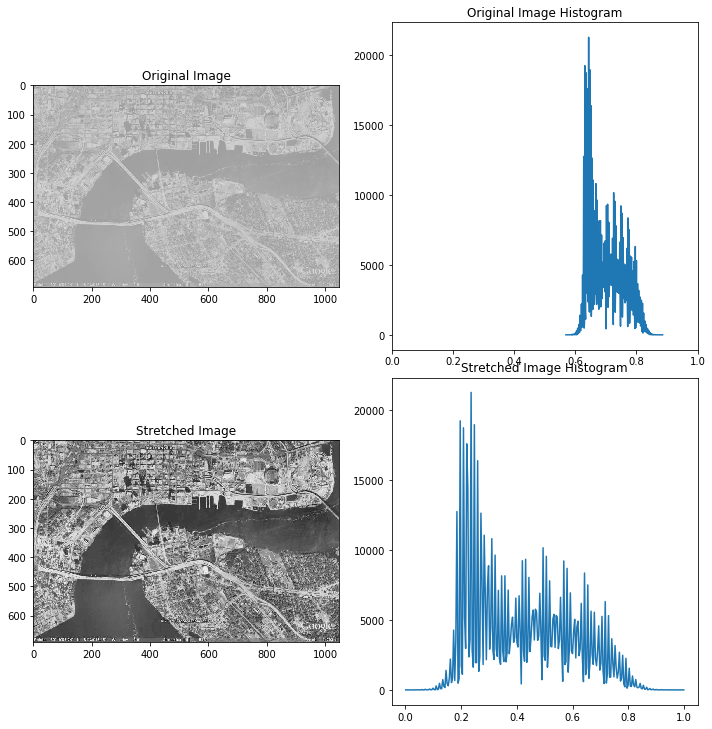

In [26]:
#Import satellite image as greyscale image and compute the histogram of the original image
img_path = './images/'
img_name = 'satellite.jpg'
satellite_im = io.imread(img_path.__add__(img_name), as_grey = True)
satellite_im_hist = exposure.histogram(satellite_im)

#Apply the function cont_str to the satellite image to obtain a new image with stretched contrast
satellite_im_stretched = cont_str(satellite_im)
hist_satellite_im_stretched = exposure.histogram(satellite_im_stretched)

#Plot the original image, its histogram, the new image, and the new histogram
fig = plt.figure(figsize=(10, 10))

plt.subplot(221)
io.imshow(satellite_im_float)
plt.title("Original Image")

plt.subplot(222)
plt.plot(satellite_im_hist[1], satellite_im_hist[0])
plt.xlim((0,1))
plt.title("Original Image Histogram")

plt.subplot(223)
io.imshow(satellite_im_stretched,cmap = cm.Greys_r)
plt.title("Stretched Image")

plt.subplot(224)
plt.plot(hist_satellite_im_stretched[1], hist_satellite_im_stretched[0])
plt.title("Stretched Image Histogram")

### Q.3 Histogram equalization
Histogram equalization can be used to enhance the contrast in images.

The idea behind the histogram equalization process is that each gray level should have an equal contribution in the image. The function allowing such transformation is in fact the cumulative density function.

**Define your own histgram equalization function, `hist_eq`**

**This function should accpet the image, max_int and min_int and return the transformed image and its cdf**

In [27]:
def hist_eq(image, max_int, min_int):
    num = max_int + min_int + 1
    cdf = exposure.cumulative_distribution(image, nbins=num)
    image = exposure.equalize_hist(image, nbins=num, mask=None)
    return image, cdf

** Use your function to transform the gray version of `satellite.jpg` image again in ubyte format**

** max_int = 255, min_int = 0 **

In [30]:
#Apply the function cont_str to the satellite image to obtain a new image with histogram equalization
satellite_im_equ, satellite_im_cdf = hist_eq(satellite_im, 0, 255)
hist_satellite_im_equ = exposure.histogram(satellite_im_equ)

**Show the transformed image and its histogram**

Text(0.5,1,'Stretched Image Histogram')

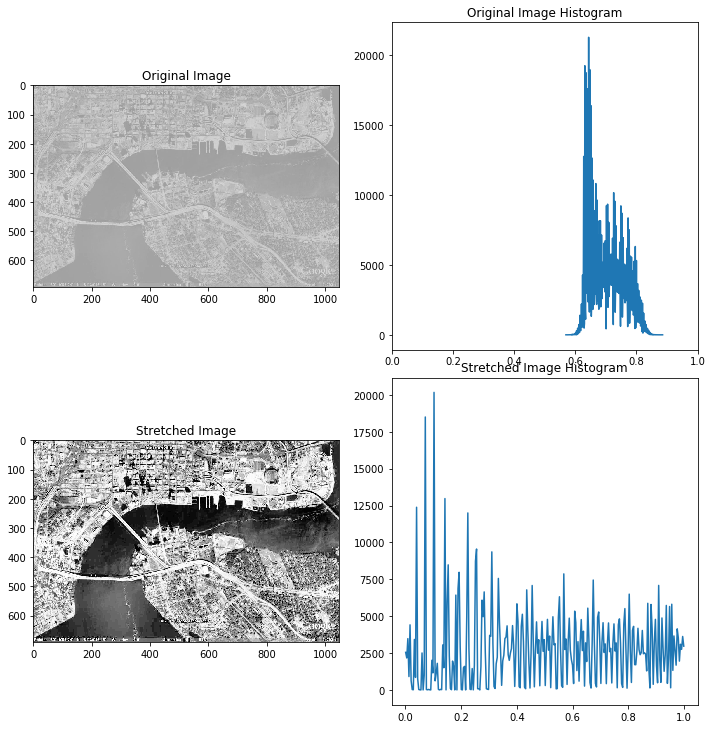

In [31]:
#Plot the original image, its histogram, the new image, and the new histogram
fig = plt.figure(figsize=(10, 10))

plt.subplot(221)
io.imshow(satellite_im)
plt.title("Original Image")

plt.subplot(222)
plt.plot(satellite_im_hist[1], satellite_im_hist[0])
plt.xlim((0,1))
plt.title("Original Image Histogram")

plt.subplot(223)
io.imshow(satellite_im_equ,cmap = cm.Greys_r)
plt.title("Stretched Image")

plt.subplot(224)
plt.plot(hist_satellite_im_equ[1], hist_satellite_im_equ[0])
plt.title("Stretched Image Histogram")


### Q.4 Histogram matching

** In this section we will perform histogram matching, the `hist_match` function is mostly defined here**
** `hist_match` uses the function that should define the Q.3 `hist_eq`, check the comments in the code as well **
 
** Explain the process of histogram matching in your own words**

In [22]:
def find_inverse_mapping(mapping):
    # Initialise the inverse
    inv_mapping = np.zeros(mapping.shape)
    # Find the index that we can affect for sure
    idx_inv_map = np.unique(mapping)
    
    # For each index
    for idx in idx_inv_map:
        # Find the corresponding index value
        int_val = np.where(mapping == idx)[0][0]
        # Affect this value for the inverse mapping
        inv_mapping[idx] = int_val
        
    # Find the first index which is not zero
    first_elt_idx = np.nonzero(inv_mapping)[0][0]
    for i, elt in enumerate(inv_mapping[first_elt_idx:-1]):
        if (elt == 0):
            inv_mapping[i + first_elt_idx] = inv_mapping[i + first_elt_idx - 1]
        
    return inv_mapping.astype('uint8')



In [23]:
def hist_match(img, pdf_to_fit, min_int, max_int):
    # Equalize img
    
    ## hist_eq is actually the function that you should implement in the previous Question 
    img_eq, cdf_eq = hist_eq(img, min_int, max_int)
   
    
    # We need to make the matching now
    ## Compute the transform G
    
    ### Compute the cdf
    cdf = np.cumsum(pdf_to_fit)
    
    ### Multiply the cdf by the number of gray values
    cdf_real = cdf * float(max_int)
    ### Round the cdf
    G = np.floor(cdf_real).astype('int')
    
    ## But we need the inverse
    G_1 = find_inverse_mapping(G)
    
    img_match = np.zeros((img_eq.shape[0], img_eq.shape[1]))
    for i in range (np.shape(img_eq)[0]):
        for j in range (np.shape(img_eq)[1]):
            img_match[i][j] = G_1[int(img_eq[i][j])]
    
    return img_match  

**Creating a manual pdf following a gaussian distribution**

In [51]:
from scipy.stats import norm

x = np.arange(max_img+1)
pdf_to_fit = norm.pdf(x, 150, 30)


**Use the defined function to match the histogram of gray version of satellite image to `pdf_to_fit`**

### Q.5 

** Explain the difference between log transform enhancement and gamma transform **


** Explain how sigmoid function enhances the image **